# Lab 08: Airline Tweets Sentiment Analysis

---
author: Qiran Hu
date: November 8, 2024
embed-resources: true
---

## Introduction

In this research, we aim to develop a sentiment classifier that accurately categorizes tweets about our airline as negative, neutral, or positive. Air travel can often be a challenging and sometimes miserable experience for passengers which lead many passengers to express their frustrations or seek support on the platform formerly known as Twitter. Travelers frequently utilize social media to complain about issues such as delayed flights, lost luggage, or poor customer service. For example, customers might engage in negative tweets on account of their terrible experiences while other customers might share positive experiences.

Traditionally, the customer service representatives from each airline have manually monitored and responded to these tweets to provide support and maintain our airline's reputation. However, the huge amount of tweets and the rapid pace of social media make it increasingly challenging to address every concern promptly and efficiently. Instead of solely relying on human to process these tweets, we propose to utilize advanced machine learning models to classify and analyze these tweets more effectively.

By training our model on historical tweets and their associated sentiments from the Twitter US Airline Sentiment dataset which is originally sourced from Kaggle and containing tweets from February 2015, we aim to create an effective and useful machine learning model that automatically classifies tweets at these airlines. This dataset has been modified to focus on feature variables of sentiment, text, and airline, which are crucial for our analysis. For instance, the dataset includes tweets like complain tweets labeled as negative and compliment tweets labeled as positive.

By implementing this model, we aim to improve our customer service by engaging with customers on social media platforms where they frequently express their experiences. Hence, this approach enhancing our customer service as well as improving each airline's reputation through important feedback from all the customers.

Although our model significantly improves the processing of social media communications, it is  important to acknowledge its limitations since this model may not capture all the nuances and contexts inherent in human language, such as sarcasm, idiomatic expressions, or complex sentiments expressed in lengthy tweets. For instance, a sarcastic tweet might be misclassified without human insight. Therefore, the sentiment classifier should be used in conjunction with human oversight to ensure the highest quality of customer engagement. As one can see, by utilizing machine learning models for sentiment analysis, we hope to assist each airline to better navigate the dynamic landscape of social media interactions and improve customer satisfaction in the near future.

## Methods

In [1]:
# imports
import numpy as np
import pandas as pd
from joblib import parallel_backend
import seaborn as sns

# data generation and loading
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import plot_tree
from sklearn.tree import export_text

# basic classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# basic regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# ensembles for classification
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# ensembles for regression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# model tuning and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

# model metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    fbeta_score,
    make_scorer,
    precision_score,
    recall_score,
)

from pprint import pprint

# other libraries
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore")


### Data

In [2]:
# load data
tweets = pd.read_csv(
    "https://cs307.org/lab-08/data/tweets.csv",
)

In [3]:
tweets

,sentiment,airline,text
0,negative,United,@united at its worse. Can't figure how to pack...
1,negative,Delta,@JetBlue I did not report the updated info - d...
2,negative,Delta,@JetBlue I'll give u a chance but I don't thin...
3,negative,United,@united Yo yo yo stuck on the tarmac for over ...
4,negative,US Airways,"@USAirways yes, I was rebooked the next day (W..."
...,...,...,...
10975,positive,Southwest,@SouthwestAir replacing @vitaminwater with bee...
10976,negative,American,@AmericanAir at LAX and your service reps just...
10977,negative,Southwest,@SouthwestAir Been on hold for over an hour - ...
10978,negative,United,@united we would...how do I contact you to dis...


To achieve the goal of this research, we will need previous tweets and their sentiment. The necessary data is provided in the following files:

Twitter US Airline Sentiment Data: tweets.csv

### Source

The data for this research originally comes from Kaggle.

Kaggle: Twitter US Airline Sentiment
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”).

We are providing a modified version of this data for this research. Modifications include:

Keeping only the airline_sentiment, text, and airline variables.
Withholding some data that will be considered the production data.

### Data Dictionary

Each observation in the train, test, and (hidden) production data contains information about a particular tweet.

#### Response Variable

**`sentiment`** - `[object]` the sentiment of the tweet. One of negative, neutral, or positive.

#### Feature Variable

**`text`** - `[object]` the full text of the tweet.

#### Additional Variable

**`airline`** - `[object]` the airline the tweet was “sent” to.

In [4]:
tweets_train, tweets_test = train_test_split(
    tweets,
    test_size=0.25,
    random_state=42,
)

In [5]:
# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

In [6]:
X_train

2233     @JetBlue Then en route to the airport the rebo...
10733    @united now you've lost my bags too.  At least...
400      @USAirways Hi, can you attach my AA FF# 94LXA6...
7615     @United, will you fill it? Yes they will. Than...
4099     @AmericanAir thanks! I hope we get movies. Tv'...
                               ...                        
5734     @united Can i get a refund? I would like to bo...
5191     @VirginAmerica what is your policy on flying a...
5390     @united I'm not sure how you can help. Your fl...
860      @VirginAmerica LAX to EWR - Middle seat on a r...
7270     @united Hopefully my baggage fees will be waiv...
Name: text, Length: 8235, dtype: object

In [7]:
word_counter = CountVectorizer()

In [8]:
word_counts = word_counter.fit_transform(
    [
        "Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo",
        "The quick brown fox jumps over the lazy dog",
        "",
    ]
).todense()

In [9]:
for key, value in word_counter.vocabulary_.items():
    print(f"{key}: {value}")

buffalo: 1
the: 8
quick: 7
brown: 0
fox: 3
jumps: 4
over: 6
lazy: 5
dog: 2


In [10]:
print(word_counts)

[[0 8 0 0 0 0 0 0 0]
 [1 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0]]


In [11]:
pd.DataFrame(
    word_counts,
    columns=sorted(list(word_counter.vocabulary_.keys())),
)

,brown,buffalo,dog,fox,jumps,lazy,over,quick,the
0,0,8,0,0,0,0,0,0,0
1,1,0,1,1,1,1,1,1,2
2,0,0,0,0,0,0,0,0,0


In [12]:
top_100_counter = CountVectorizer(max_features=100)
X_top_100 = top_100_counter.fit_transform(X_train)
print("Top 100 Words:")
print(top_100_counter.get_feature_names_out())
print("")

Top 100 Words:
['about' 'after' 'again' 'airline' 'all' 'am' 'americanair' 'amp' 'an'
 'and' 'any' 'are' 'as' 'at' 'back' 'bag' 'be' 'been' 'but' 'by' 'call'
 'can' 'cancelled' 'co' 'customer' 'delayed' 'do' 'don' 'flight'
 'flightled' 'flights' 'for' 'from' 'gate' 'get' 'got' 'had' 'has' 'have'
 'help' 'hold' 'hour' 'hours' 'how' 'http' 'if' 'in' 'is' 'it' 'jetblue'
 'just' 'late' 'like' 'me' 'my' 'need' 'no' 'not' 'now' 'of' 'on' 'one'
 'or' 'our' 'out' 'over' 'phone' 'plane' 'please' 're' 'service' 'so'
 'southwestair' 'still' 'thank' 'thanks' 'that' 'the' 'there' 'they'
 'this' 'time' 'to' 'today' 'united' 'up' 'us' 'usairways' 've'
 'virginamerica' 'was' 'we' 'what' 'when' 'why' 'will' 'with' 'would'
 'you' 'your']



In [13]:
X_top_100_dense = X_top_100.todense()
X_top_100_dense

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [14]:
X_top_100.shape

(8235, 100)

In [15]:
plane_idx = np.where(top_100_counter.get_feature_names_out() == "plane")
plane_count = np.sum(X_top_100.todense()[:, plane_idx])
print('The Word "plane" Appears:', plane_count)

The Word "plane" Appears: 362


In [16]:
# summary statistics
tweets_train.shape[0]

8235

In [17]:
tweets_train.shape[1]

3

In [18]:
len(tweets_train[tweets_train["airline"] == "United"])

2166

In [19]:
len(tweets_train[tweets_train["airline"] == "United"]) / len(tweets_train)

0.263023679417122

In [20]:
len(tweets_train[tweets_train["airline"] == "US Airways"])

1664

In [21]:
len(tweets_train[tweets_train["airline"] == "US Airways"]) / len(tweets_train)

0.20206435944140863

In [22]:
len(tweets_train[tweets_train["airline"] == "American"])

1551

In [23]:
len(tweets_train[tweets_train["airline"] == "American"]) / len(tweets_train)

0.1883424408014572

In [24]:
len(tweets_train[tweets_train["airline"] == "Southwest"])

1347

In [25]:
len(tweets_train[tweets_train["airline"] == "Southwest"]) / len(X_train)

0.16357012750455374

In [26]:
len(tweets_train[tweets_train["airline"] == "Delta"])

1239

In [27]:
len(tweets_train[tweets_train["airline"] == "Delta"]) / len(X_train)

0.15045537340619308

In [28]:
len(tweets_train[tweets_train["airline"] == "Virgin America"])

268

In [29]:
len(tweets_train[tweets_train["airline"] == "Virgin America"]) / len(X_train)

0.03254401942926533

In [30]:
plane_idx = np.where(top_100_counter.get_feature_names_out() == "cancelled")
plane_count = np.sum(X_top_100.todense()[:, plane_idx])
print('The Word "cancelled" Appears:', plane_count)

The Word "cancelled" Appears: 595


In [31]:
plane_idx = np.where(top_100_counter.get_feature_names_out() == "please")
plane_count = np.sum(X_top_100.todense()[:, plane_idx])
print('The Word "please" Appears:', plane_count)

The Word "please" Appears: 325


In [32]:
plane_idx = np.where(top_100_counter.get_feature_names_out() == "thanks")
plane_count = np.sum(X_top_100.todense()[:, plane_idx])
print('The Word "thanks" Appears:', plane_count)

The Word "thanks" Appears: 587


The dataset provides valuable insights into airline tweet sentiments and customer feedback by offering useful information for sentiment analysis and service improvement strategies. The tweets are classified into three sentiment categories which are negative, neutral, and positive. With a majority of negative tweets in this dataset, this finding indicates that customers often use social media to express their complaints and dissatisfactions with airline services. The distribution of tweets across airlines reveals that United Airlines has the highest number of tweets with 2166 related tweets which is around 26.2% of the total tweets. US Airways has the second highest number of tweets with 1664 related tweets which is around 20% of the total tweets. American Airlines has the third highest number of tweets with 1551 related tweets which is around 18.8% of the total tweets. Southwest has the fourth highest number of tweets with 1347 related tweets which is around 16.5% of the total tweets. Delta has the fifth highest number of tweets with 1239 related tweets which is around 15% of the total tweets. Lastly, Virgin America has the smallest representation with only 268 related tweets which is around 3.3% of the total tweets. Hence, these summary statistics illustrate various levels of customer interaction and engagement across different airlines.

The frequent use of specific words offers a different perspective in analyzing customer tweets. For instance, the word cancelled appears 595 times which reflects a significant operational challenge faced by airlines. This high frequency demonstrates that flight cancellations are a common issue that customers complain about which emphasizes the importance of addressing this issue in order to improve overall customer satisfaction. Interestingly, the word thanks appears 587 times which suggests that a substantial number of tweets express gratitude towards different airlines. These positive mentions could be related to successful resolutions of issues, such as good service experiences or effective customer support interactions. Thus, this result provides significant evidence that there is still a noticeable proportion of customer appreciation despite the astonishing amount of negative sentiments in this dataset, which means that different airlines could build stronger relationships with their customers by reflecting on these tweets from their customers. Furthermore, the word please appears 325 times which shows that there are various requests or appeals made by customers who are seeking assistance or resolutions to their problems. The presence of such words in the dataset signals the need for improved communication and customer service from different airlines to address these requests efficiently which highlights the importance of customer service as a crucial factor in shaping the overall sentiment and perception of different airlines.

Hence, the analysis of word occurrences provides helpful insights for airlines to prioritize their efforts where the high occurrences of cancelled demonstrate the urge to minimize cancellations and streamline rebooking processes. The appearance of thanks indicates areas where airlines have successfully met customer expectations. By addressing customer requests, the high frequency the word please illustrates that different airlines can improve foster a more positive customer experience. These trends indicate the importance of analyzing customer feedback in order to uncover specific issues and opportunities for improving service quality and satisfaction.

As one can see, the dataset provides a clear opportunity for airlines to identify and address service challenges. The high frequency of words like cancelled shows that there are various issues could be addressed in order to improve customer experiences in the near future. Meanwhile, analyzing the positive sentiment seen with airlines like Southwest and Virgin America could increase customer engagement and satisfaction. By correctly utilizing the information from this dataset, different airlines can focus on resolving common complaints, amplifying positive experiences, and improving their overall service and communication strategies to strengthen their brand perception and improve customer loyalty.

<Figure size 1000x600 with 0 Axes>

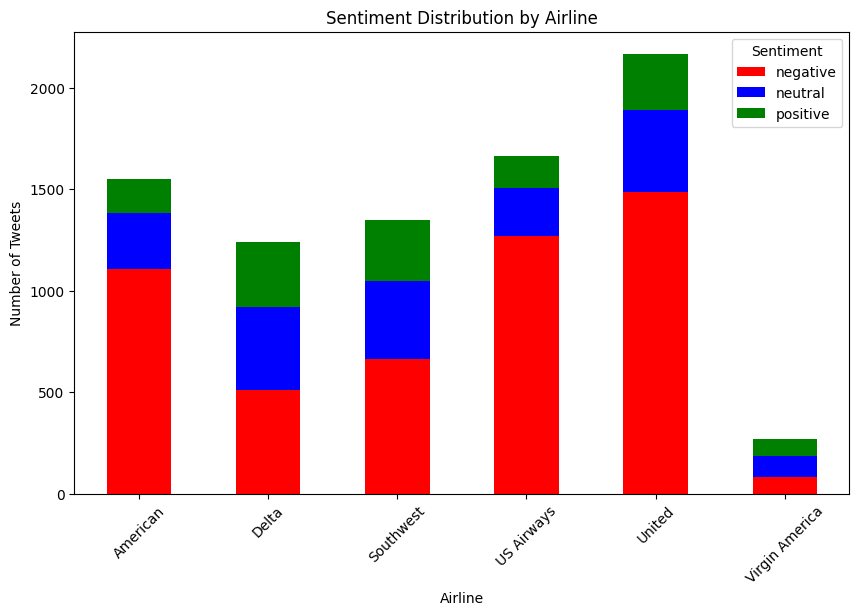

In [33]:
# visualizations
plt.figure(figsize=(10, 6))
sentiment_counts = tweets_train.groupby(["airline", "sentiment"]).size().unstack().fillna(0)
sentiment_counts.plot(kind="bar", stacked=True, color=["red", "blue", "green"], figsize=(10, 6))
plt.title("Sentiment Distribution by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment", loc="upper right")
plt.xticks(rotation=45)
plt.show()

After carefully observing the graph, the bar chart visualization of sentiment distribution by airline offers a detailed information of customer feedback across various airlines by highlighting the differences in customer satisfaction levels. Since each airline’s sentiment distribution is color coded to represent negative, neutral, and positive sentiments, it is extremely easy to compare customer perceptions based on different airlines.

For instance, United Airlines has the highest volume of negative sentiment with a substantial number of tweets in red. It suggests that customers frequently express dissatisfaction with this airline because this trend could be attributed to recurring complaints about delayed flights, poor customer service, or issues with frustrations for airline passengers. Hence, this high level of negative sentiment indicates that United has to work on improving operational efficiency and customer support to address these complains. Similarly, American Airlines shows a high count of negative tweets compared to other airline. It demonstrates that American Airlines also faces significant customer service challenges since presence of numerous negative sentiments could imply that American is facing similar issues as United, which means addressing these issues could help American reduce negative sentiment and enhance customer satisfaction.

On the other hand, Southwest Airlines displays a more balanced sentiment distribution with a mix of positive, neutral, and negative tweets. Southwest has a notably larger proportion of positive sentiment compared to United and American which illustrate that customers had better experiences with Southwest. Thus, the presence of a significant amount of positive sentiment shows that Southwest is effectively meeting customer expectations in certain areas and setting itself apart from airlines with predominantly negative sentiment.

Like United and American, US Airways has a substantial amount of negative feedback even though it also has some positive and neutral comments. This distribution showcases that there are pockets of positive interactions despite the fact that many customers had negative experiences. However, Virgin America has more balanced sentiment distribution with a relatively small number of negative tweets and a proportionate amount of neutral and positive feedback, which shows that Virgin America provides a more consistent satisfactory experience overall. With a substantial portion of negative tweets as well as positive and neutral feedback, this mix suggests that Delta’s service quality varies with some customers having satisfactory experiences while others encounter issues.

As one can see, this bar chart provides a comprehensive view of customer sentiment across airlines by illustrating the areas where each airline excels or faces challenges. For airlines like United and American, the high levels of negative sentiment emphasize the need to address customer service issues. Conversely, the positive feedback for Southwest suggests that there are rooms to improve customer loyalty. As one can see, this visualization is valuable for airlines that are aiming to refine their customer service strategies and focus on areas that impact customer perceptions the most.

### Models

In [34]:
# process data for ML
pipeline = Pipeline(
    steps=[
        ("Preprocessor", CountVectorizer()),
        ("regressor", LogisticRegression()),
    ]
)

In [35]:
param_grid = [
    {
        "regressor": [DecisionTreeRegressor()],
        "regressor__max_depth": range(1, 30, 10),
        'regressor__min_samples_split': range(2, 30, 5),
    },
    {
        "regressor": [LogisticRegression(solver="liblinear")],
        "regressor__penalty": ["l1", "l2"],
        "regressor__C": 1 / (10.0 ** np.arange(-4, 3)),
    },
]

In [36]:
# train models
mod = GridSearchCV(pipeline, param_grid, cv = 5, scoring='accuracy')

In [37]:
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor', CountVectorizer()),
                                       ('regressor', LogisticRegression())]),
             param_grid=[{'regressor': [DecisionTreeRegressor()],
                          'regressor__max_depth': range(1, 30, 10),
                          'regressor__min_samples_split': range(2, 30, 5)},
                         {'regressor': [LogisticRegression(solver='liblinear')],
                          'regressor__C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02]),
                          'regressor__penalty': ['l1', 'l2']}],
             scoring='accuracy')

In order to develop an effective model to classify tweets based on their sentiments, we implemented and evaluated two different machine learning models, which are decision tree regressor and logistic regression regressor. Given the textual nature of the data where each tweet is composed of unstructured text, it is important to preprocess the data appropriately to make it suitable for machine learning algorithms.

By processing the dataset into the target variable and the feature variables for both training and testing datasets, we obtain our feature variable from our dataset which is the text of the tweets. Since it is unstructured data and it requires transformation into a numerical format, we utilized the CountVectorizer from scikitlearn to make it suitable for machine learning algorithms, which converts the text data into a matrix of token counts by effectively capturing the frequency of words used in each tweet.

To optimize the model's performance, we constructed a pipeline that integrated the preprocessing step with both logistic regression regressor and decision tree regressor so that we can compare different machine learning algorithms to explore their potentials in handling this classification problem due to its ability to model complex nonlinear relationships. We conducted an extensive grid search over a range of hyperparameters to tune the models. For decision tree regressor, we explored the max depth parameter from 1 to 30 with increments of 10 and adjusted the min samples split from 2 to 30 with increments of 5 where these hyperparameters control the complexity of the tree and the minimum number of samples required to split an internal node respectively. For the logistic regression regressor, we experimented different regularization penalties of l1 and l2 penalties with varied the inverse regularization strength C from 1 / 0.0001 to 1 / 100, which allows us to balance the trade off between model complexity and performance. Futhermore, these models were evaluated using 5 fold cross validation with accuracy as the scoring metric to ensure a robust assessment of their predictive performance. With 5 fold cross validation, it helps us to assess how the results of our model will generalize to an new dataset as well as preventing overfitting.

While our models significantly improve the efficiency of processing customer service through social media platforms by automatically classifying tweet sentiments, it is crucial to acknowledge their limitations because models may not capture all the details in these tweets like sarcasm and idiomatic expression. For instance, a tweet with sarcastic language may be misclassified as positive tweet without human supervision. Therefore, integrating advance machine learning models could improve the overall effectiveness of the sentiment analysis system.

As one can see, by experimenting  both logistic regression regressor and decision tree regressor with well constructed pipelines and optimizing their hyperparameters, we have developed a strong sentiment classifier that enables our customer service team to make correct decisions from tweets so that we can improve our engagement with customers and maintain each airline's reputation in the fast paced environment of social media during the digital era.

## Results

In [38]:
# report model metrics
# print search results
print("Best parameters found:", mod.best_params_)
print("Best cross-validated accuracy:", mod.best_score_)

# evaluate and print test metrics
test_score = mod.score(X_test, y_test)
print(f"Test accuracy: {test_score:.2f}")

Best parameters found: {'regressor': LogisticRegression(solver='liblinear'), 'regressor__C': np.float64(1.0), 'regressor__penalty': 'l2'}
Best cross-validated accuracy: 0.7859137826350941
Test accuracy: 0.80


In [39]:
from joblib import dump
dump(mod, "airline-sentiment.joblib")

['airline-sentiment.joblib']

After training and validation, the we identified the optimal hyperparameters from GridSearchCV is the logistic regression regressor with a penalty of l2 and a regularization strength of C = 1.0. By utilizing the logistic regression regressor with these optimized parameters, our model effectively classifies tweets into negative, neutral, or positive sentiments. This significantly improves our ability to monitor and respond to customer feedback on social media which perfectly alligns with our goal to improve customer engagement and satisfaction.

To develop a efficient sentiment classifier with strong predictive power, we constructed a machine learning pipeline that integrates text preprocessing by using the CountVectorizer to convert the textual tweet data into numerical features in order to transform each tweet into a vector of word counts, which is an important step to handle unstructured text data and preparing it for model training.

We also explored both logistic regression regressor and decision tree regressor within our pipeline to determine the optimal performance. we performed an extensive grid search using GridSearchCV over a range of hyperparameters for both models. For the logistic regression regressor, we experimented with different regularization penalties of l1 and l2 to prevent overfitting and varied the inverse regularization strength across several orders of magnitude by computing C from 1 / 0.0001 to 1 / 100. For the decision tree regressor, we used parameters of max depth from 1 to 30 with increments of 10 and min samples split from 2 to 30 with increments of 5 to control the complexity of the tree.

Then, we evaluated the performance of each model using 5 fold cross validation with accuracy as the scoring metric which ensures that the model's ability to generalize on unforeseen dataset. As a result, the GridSearchCV revealed that the Logistic Regression model with an l2 penalty and C = 1.0 achieved the best performance, with a best cross validated accuracy of 0.7859137826350941 and a test accuracy of 0.8. In contrast, the decision tree regressor did not perform as well because it is not inherently designed for classification tasks which may not effectively handle discrete sentiment categories. Therefore, the high test accuracy demonstrates the model's effectiveness in accurately identifying different types of tweets. With its ability to handle large volume of text data and makes correct sentiment classifications, the logistic regression regressor becomes the best choice for our application.

By integrating this model into our social media monitoring system, we can efficiently process the huge amount of tweets that are directed at our airline and effectively addressing customers' feedback, which streamlines our customer service operations as well as increasing our brand reputation. Despite the fact that our current model performs well on this dataset, we have to acknowledge that natural language processing is a complex field with. Without incorporating advanced text features, we might not be able to capture more detailed textual information and further enhance performance. For instance, developing a machine learning model to detect sarcasm or understand context could significantly enhance classification accuracy for tweets with implicit sentiments.

As one can see, by continuously refining our model and incorporating new features, we aim to maintain a high accuracy of classifying customer engagement and satisfaction on social media platforms. With our high predictive power machine learning models for sentiment analysis, we can better navigate the dynamic landscape of social media interactions and improved customer satisfaction for each airline.

## Discussion

By utilizing a sentiment classifier to monitor tweets for each airline, there are several potential mistakes could arise from the model's limitations which could lead to sever issues. One of the primary concerns is the misclassification of negative tweets as neutral or negative tweets since the false negative tweets are particularly severe on account of the fact that failing to address these issues could lead to increased customer dissatisfaction and potential loss of our clients, which negatively damage each airline's reputation and revenue. 

Conversely, the model might also classify neutral or positive tweets as negative tweets. Although it is less severe than missing negative feedback, this mistake can result in unnecessary allocation of customer service resources to address these issues. For instance, if the model interprets some neutral tweets as negative tweets instead, customer service might confuse the customer with unwarranted apologies or offers of assistance. Hence, this misallocation of resources can reduce the efficiency of our customer service operations since our customer service might spend time addressing tweets that do not require intervention which ultimately diverts attention from customers who need assistance from our customer service. Another potential mistake is the confusion between positive and neutral sentiments. The model may occasionally misclassify neutral content as positive or vice versa which causes more confusions between our customer service and the passengers. For instance, interpreting a neutral statement as positive could trigger an automated response that feels insincere or robotic will diminish credibility among our clients. Conversely, overlooking positive sentiments leads to missing opportunities for meaningful engagement and fostering relationship between our customer service and clients. Thus, these misclassifications underscore the importance of improving our models to effectively interact with different customers.

This model also encounters significant challenges when attempting to process the complexities of natural language on  social media platforms. One critical limitation is its inability in detecting advance linguistic features, such as sarcasm, irony, or mixed sentiments. These language forms often carry underlying meanings that contradict their surface expressions which makes them more likely to be misclassified. Therefore, misinterpretations can lead to inappropriate or ineffective responses and lead to negative impacts on our customer service. Another major issue arises from the model's limitation to consider contextual elements where some tweets are often depending on conversational history, previous interactions, or external events. Without a comprehensive understanding of these factors, the model risks oversimplifying sentiments or missing critical emotional expressions, which can result in ignoring customer concerns repeatedly.

Handling ambiguous or multifaceted sentiments also presents difficulties since social media platforms often blend positive and negative emotions in a single tweet. The model trend to classify such messages into singular categories may lead to incomplete interpretations which leads to failures to address specific concerns or appreciate positive feedback. Additionally, the model struggles with distinguishing between meaningful feedback and irrelevant content like spams or promotional materials where misclassifications in this area would waste operational resources and expose the organization to reputational risks. Futhermore, new slang, abbreviations, and expressions frequently emerge on social media platforms which makes our model less likely to classify these tweets; this limitation reduces our model's capacity to engage effectively with our customers and maintain relevance in the digital era. These challenges highlight the need for a more robust approach to sentiment analysis, incorporating advanced contextual understanding, adaptive learning mechanisms, and continuous updates to ensure alignment with evolving language trends. Addressing these limitations is essential for delivering accurate, personalized, and meaningful interactions that enhance customer engagement and trust.

As one can see, it is vital that we need to be aware of these potential mistakes even though our sentiment classifier improves our ability to process and respond to customer feedback efficiently where severities of these mistakes range from inefficient use of resources to significant impacts on customer satisfaction and brand reputation. By implementing additional features like incorporating advanced natural language processing techniques to detect sarcasm and context and regularly updating the model to accommodate different context, these approaches could address these challenges so that we can confidently use the model to support our customer service and maintain improve customer satisfaction and loyalty un the near future.

### Conclusion

In this research, we developed a sentiment classifier by experimenting logistic regression regressor and decision tree regressor to categorize tweets that are directed at each airline into negative, neutral, or positive sentiments. The model was optimized through GridSearchCV with the best parameters of the logistic regression regressor with l2 penalty and a regularization strength of C = 1.0. The model achieved a best cross validated accuracy of 0.7859137826350941 and a test accuracy of 0.80, which indicates an outstanding performance in classifying sentiments based on textual data.

However, we would not recommend implementing this model in practice on account of its significant drawbacks which means that deploying this model in real world scenario is not feasible. One critical concern is that the misclassification of negative tweets as neutral or positive tweets where customer complaints might go unnoticed. Thus, the lack of timely response can exacerbate customer dissatisfaction and harm each airline's reputation that could result in the loss of customer satisfaction and revenue.

The model also struggles with detecting sarcasm, irony, and advanced language usage in social media communication. Misinterpreting sarcastic complaints as positive sentiments can lead to inappropriate responses, which could further frustrate customers during their traveling. In addition, the model's inability to handle ambiguous or mixed sentiments leads significant challenges since most of the tweets contain complex sentiments or references about previous interactions that the model cannot accurately interpret without contextual information, which results in inadequate responses that fail to fully address customer feedback. Moreover, the reliance on historical data means the model may not adapt well to new slang and abbreviations where misinterpretation of new expressions or trending phrases could result in inappropriate responses and significantly decrease customer satisfaction.

Given these limitations, the risks that are associated with misclassifications outweigh the benefits of automating sentiment analysis with the current model's capabilities. Therefore, despite the model's reasonable accuracy, we recommend not implementing this model in practice. Instead, we suggest to explore more advanced natural language processing techniques that can better handle the complexities of human language, such as sarcasm detection.

As one can see, by prioritizing customer satisfaction and brand reputation, we recommend maintaining a human centered approach to monitor and respond to social media tweets with a more reliable and sophisticated machine learning model. Thus, this approach ensures that customer interactions are handled appropriately in the near future.